In [21]:
# basic imports

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import meanz_modules as mzmod

Based on remapping the SRD distributions to alpha = 0.92,
    $z0$ parameter of z distribution vs i limiting magnitude $i_{lim}$ is:
 $z0 = 0.246 + 0.025*(i_{lim}-24.1)$

 Note that all Jeff's code has been moved to the meanz_modules code for repeated use elsewhere

In [28]:
# First, we are going to create Monte Carlo samples from the SRD
# distributions of i magnitude and p(z | i)

# set up to make interpolation tables
# can change the i magnitude range of objects or the z
# range to consider in this cell
imin = 17
imax= 27
ni = 101

zmin = 0
zmax = 4
nz = 401

In [5]:
#needed the below for %%timeit to work and the slow generation step not to be even slower due to error messages

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [6]:
from photerr import LsstErrorModel
# import pkg_resources

# dists = [str(d).replace(" ","==") for d in pkg_resources.working_set]
# for i in dists:
#     print(i)

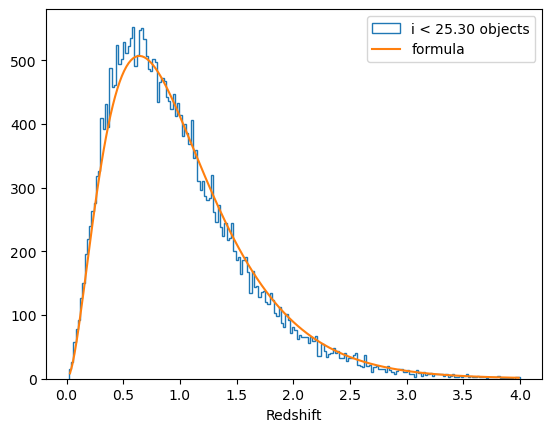

In [35]:
import importlib
import pandas as pd
importlib.reload(mzmod)
#check redshift distributions

imag=25.3 # this can change

z0 = 0.246 + 0.025*(imag-24.1)

generate = True
number_of_mcmc_iterations = 300000
if generate:
    catalog = mzmod.generate_zdistribution(n_mc=number_of_mcmc_iterations,imin=17,imax=28,ni=101, zmin=0,zmax=4,nz=401,filename='zdist.pkl')
else:
    catalog = pd.read_pickle('zdist.pkl')

zdist = catalog[catalog['i'] < 25.3]['zarr']
n,bins,edges = plt.hist(zdist,bins=200,histtype = 'step',label='i < %2.2f objects'%imag)

z=(bins[0:-1]+bins[1:])/2.
zdist = z**2*np.exp(-(z/z0)**0.92)
plt.plot(z,zdist*np.sum(n)/np.sum(zdist),label='formula')
plt.xlabel('Redshift')
plt.legend()

#this looks very slightly off, maybe due to plotting curve at bin center 
# vs. integrating over bin? Regardless seems good enough for what we are doing

In [45]:
# set up grid of 5 sigma depths to consider

m5s = np.linspace(25.75,28.25,26)
print(m5s)

[25.75 25.85 25.95 26.05 26.15 26.25 26.35 26.45 26.55 26.65 26.75 26.85
 26.95 27.05 27.15 27.25 27.35 27.45 27.55 27.65 27.75 27.85 27.95 28.05
 28.15 28.25]


In [48]:
# Need to  apply flux errors for different 
# depths as a function of true i magnitude. 

# note error in magnitude = 2.5/ln(10)*(sigma_f/f)
importlib.reload(mzmod)
summary_filename = 'results.pkl'
outputs = mzmod.grid_deltaz(num_m5s=26,m5min=28.25,m5max=25.75,imag=25.3,catalog_mc=100000,flux_var=0.01, generate_zdist=False,zdistfile='zdist.pkl')


[25.75 25.85 25.95 26.05 26.15 26.25 26.35 26.45 26.55 26.65 26.75 26.85
 26.95 27.05 27.15 27.25 27.35 27.45 27.55 27.65 27.75 27.85 27.95 28.05
 28.15 28.25]


Text(0, 0.5, '$\\Delta$ <z>')

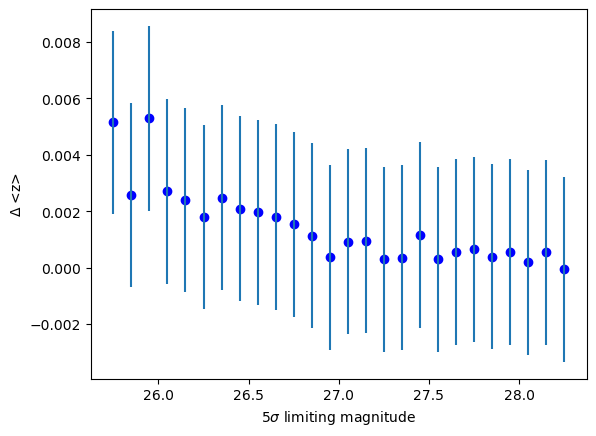

In [49]:
plt.plot(outputs['m5'],outputs['meanz']-outputs['true_meanz'],'bo')
plt.errorbar(outputs['m5'],outputs['meanz']-outputs['true_meanz'],outputs['meanz_err'],
            fmt='none')
plt.xlabel(r'5$\sigma$ limiting magnitude')
plt.ylabel(r'$\Delta$ <z>')

Text(0, 0.5, '$\\Delta \\Sigma / \\Sigma$')

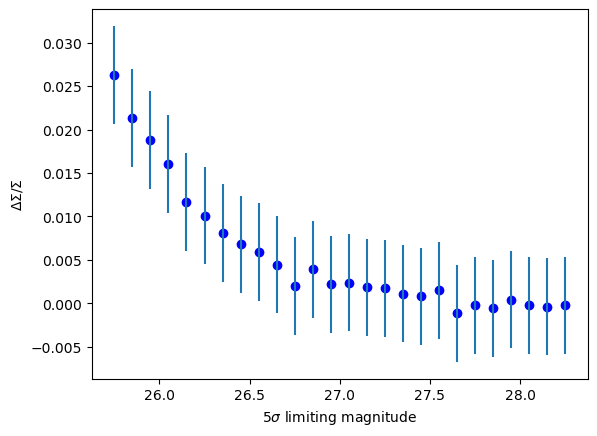

In [50]:
plt.plot(outputs['m5'],outputs['number']/outputs['true_n'] - 1,'bo')
plt.errorbar(outputs['m5'],outputs['number']/outputs['true_n'] - 1,outputs['number_err']/outputs['true_n'],
            fmt='none')
plt.xlabel(r'5$\sigma$ limiting magnitude')
plt.ylabel(r'$\Delta \Sigma / \Sigma$')

In [17]:
# example calculations

print(f'true photometry <z> for < {imag}: {np.mean(true_z[true_i < imag]):.4f}')
print(f'noisy photometry <z> for < {imag}: {np.mean(true_z[noisy_i < imag]):.4f}')
print(f'delta <z>: {np.mean(true_z[noisy_i < 25.3]) - np.mean(true_z[true_i < imag]):.4f}')
print(f'error on delta <z>: {np.sqrt(2)*np.std(true_z[true_i < imag])/np.sqrt(np.sum(true_i < imag)):.4f}')


true photometry <z> for < 25.3: 0.9723
noisy photometry <z> for < 25.3: 0.9729
delta <z>: 0.0006
error on delta <z>: 0.0031


In [16]:
print(f'true # of objects < {imag}: {np.sum(true_i < imag):.5g}')
print(f'noisy # of objects < {imag}: {np.sum(noisy_i < imag):.5g}')
print(f'fractional change: {(np.sum(noisy_i < imag) - np.sum(true_i < imag))/np.sum(true_i < imag):.4f}')
print(f'error on fractional change: {np.sqrt(np.sum(noisy_i < imag) + np.sum(true_i < imag))/np.sum(true_i < imag):.4f}')

true # of objects < 25.3: 73400
noisy # of objects < 25.3: 73459
fractional change: 0.0008
error on fractional change: 0.0052


In [ ]:
# ~1 sec to generate 10k MCs

# ~10 sec to add noise and calculate statistics for 1 choice of depth, 30M MCs


In [19]:
import os.path
filename = 'deltaz_outputs_dataframe.pkl'

if (os.path.isfile(filename) == False):
    generate = True 
    
print(generate)

True


In [20]:
generate = False

# Various code from when I was playing with things is below, kept in case you want to check intermediate steps

In [ ]:
# ignore this
# didn't get interpolation to work, let's not calculate this
# for now
if 0:
    dndis = (0.868296*10**(0.359*(ivals-25))
         *exp(-(zvals/z0s)**0.92)*zvals**3)/( (z0s**2)*(zvals/z0s)**0.08) 

    dndis += 31.2069*10**(0.359*(ivals-25))*exp(-(zvals/z0s)**0.92)*zvals**2
    dndis[np.isfinite(dndis) == 0] = 0.

    cumzdist = np.zeros_like(dndis)

    cumzdist = np.cumsum(dndis,axis = 0)
    for i in arange(ni):
        cumzdist[:,i]=cumzdist[:,i]/cumzdist[nz-1,i]

In [ ]:
#ignore this

#nyears = 10.0
#nvisits_i = 18.4

# nominal depth from ivezic et al. 2018
#nominal_depth = 23.92+2.5*np.log10(nyears*nvisits_i)/2.
#m5_nominal = np.min(catalog_with_errors[ 
#      catalog_with_errors['i_err'] > 0.2*2.5/np.log(10)]['i'])

# make a grid in number of years, 
#    and calculate the corresponding m5 values
#nyears = np.logspace(np.log10(2),np.log10(50),21)
#m5s = m5_nominal +2.5*np.log10(nyears/10.)/2.

In [ ]:
alpha_mid = 0.92
z0_mid = 1
intz3_mid = 1/alpha_mid*z0_mid**4*sp.special.gamma(4/alpha_mid)
intz2_mid = 1/alpha_mid*z0_mid**3*sp.special.gamma(3/alpha_mid)
znorm_mid=intz3_mid/intz2_mid

In [ ]:
# you can safely ignore all this stuff --
# the next few cells are just figuring how to remap the SRD 
# redshift distributions to use fixed alpha=0.92 instead
# of alphas of 0.9 and 0.94, keeping mean z the same

alpha10 = 0.9
z0_10 = 0.28
intz3_y10 = 1/alpha10*z0_10**4*sp.special.gamma(4/alpha10)
intz2_y10 = 1/alpha10*z0_10**3*sp.special.gamma(3/alpha10)
zavg_10=intz3_y10/intz2_y10
znorm_10 = zavg_10/z0_10

In [ ]:
alpha1 = 0.94
z0_1 = 0.26
intz3_y1 = 1/alpha1*z0_1**4*sp.special.gamma(4/alpha1)
intz2_y1 = 1/alpha1*z0_1**3*sp.special.gamma(3/alpha1)
zavg_1=intz3_y1/intz2_y1
znorm_1 = zavg_1/z0_1

In [ ]:
# equivalent z0 values for fixed alpha = 0.92
z0_1m = z0_1*znorm_1 / znorm_mid
z0_10m = z0_10*znorm_10 / znorm_mid

In [ ]:
# calculated the derivative of SRD n(<i,z) with respect to i
# limiting magnitude using Wolfram alpha.  The below is example 
# code that calculates the distribution of z at magnitude 
# ival (rather than for i < ival)

z=np.linspace(0,4,401)
ival=24.1
z0 = 0.246 + 0.025*(ival-24.1)

# tested this vs. the differential
# redshift distribution for a small delta-z, looks good

dndi = (0.868296*10**(0.359*(ival-25))
         *np.exp(-(z/z0)**0.92)*z**3)/( (z0**2)*(z/z0)**0.08) 

dndi += 31.2069*10**(0.359*(ival-25))*np.exp(-(z/z0)**0.92)*z**2
dndi[0]=0.

# note: the warning you get is due to a NaN at z = 0, 
# which this code fixes

/var/folders/15/b92d0zld655f8g95h7_482c40000gt/T/ipykernel_49940/4147977768.py:13: RuntimeWarning: invalid value encountered in divide
  dndi = (0.868296*10**(0.359*(ival-25))
